#  Problem Set

## Christopher Zhen



### Problem 1

In this problem, we want to design a stickman by generating a random sequence and mutating the sequence until we reach a threshold determined by either MFE defect or ensemble defect optimization.

a. In order to do this, we first need a function that generates a sequence that allows for base-pairing in the desired structure. We'll do this for a given dot-parens structure without pseudoknotting:

In [2]:
import numpy as np
import random
from IPython.display import Image 
import sys
sys.path.append('/home/jovyan/work')
import nupack.utils as npk
import random
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from timeit import default_timer as timer

In [35]:
def randseq(structure):
    """
    Generate a random sequence that satisfies the complemntarity defined
    using the parentheses form 
    """
    N = len(structure)
    bases = ['A','C','G','U']
    
    # Initialize sequence with random bases
    sequence = list(np.random.choice(bases, size=N))
    
    # Iterate through all the bases and make sure it matches the desired structure
    for i in range(N):
        
        # For every open parens, find corresponding closed parens
        if structure[i] == '(':
            check = 1
            j = copy.copy(i)
            
            # Search for closed parens
            while check != 0 or structure[j] != ')':
                j += 1
                if structure[j] == '(':
                    check += 1
                if structure[j] == ')':
                    check -= 1
                    
            # Change closed parens to matching base
            sequence[j] = bases[3-bases.index(sequence[i])]
    return "".join(sequence)

def checker(seq):
    """ 
    Hard coded function to check a small area of loop for debugging 
    """
    bases = 'ACGU'
    false = 0
    
    # Hard-coded area of loop to check
    for i in range(25,31):
        if bases.index(seq[i])+bases.index(seq[46-i]) != 3:
            false += 1
    return false

stickman = '..((((((((..((((((((((...))))))(((.........)))((((((...))))))))))..((((((((...)))))))))))))))).'
print(randseq(stickman))
print(checker(randseq(stickman)))
seq1 = randseq(stickman)
seq2 = randseq(stickman)
seq3 = randseq(stickman)
seq4 = randseq(stickman)
seq5 = randseq(stickman)

CCUGUACGCGUGUGCAGACUCGGUCCGAGUCGAAUUUUGCUCCUUCGCUUUGGUGCAAAGCUGCAAAUGUCCUAGCUGCUAGGACACGCGUACAU
0


In [36]:
print('sequence 1 = ' + seq1)
print('sequence 2 = ' + seq2)
print('sequence 3 = ' + seq3)
print('sequence 4 = ' + seq4)
print('sequence 5 = ' + seq5)

sequence 1 = UACUUAGCUUUGAUGUAUAGCCGUCGGCUAUCGUGUGCCGUUUACGGGCUGGCUUCCAGCCACAUAAAAGGGUGGGAGCCACCCUUAAGCUAAGG
sequence 2 = AACAAUGACCAAGGGAAGGACUUUAAGUCCUUUUAUACGCUGCAAACCAGGCAGCGCCUGGUCCCAUGUAGACGGCAUCCGUCUACGGUCAUUGC
sequence 3 = GGCAUUCACGAUUCGCCCAUCAGUUUGAUGGUAUGCGUGACAAAUAUAGCAGCGACUGCUAGCGACUACGUCCCUAACAGGGACGUCGUGAAUGC
sequence 4 = UCCUAGUGCUAAUGCUUUCUCCAACGGAGAAAGGCGCGGGGUACCUGUCUGGGAGCCAGACAGCAGAAGGAGGUCUCGGACCUCCUAGCACUAGC
sequence 5 = AAUUCGGGGCUGCUACGCGAUCCAAGAUCGCACCACUACAAACGGUGGGCAGUCGCUGCCCGUAGAUGCGCCACGCGACGUGGCGCGCCCCGAAG


Shown above are the 5 randomly generated sequences

b & c. Now using these sequences, we'll optimize for the mfe defect and ensemble defect using the following code:

In [37]:
def pairs(structure): 
    """ 
    Use Nupack packages to consturct a matrix of all paired bases for structure 
    """
    N = len(structure)
    pairs = np.zeros([N,N+1])
    pairlist = npk.dotparens_2_pairlist(structure)[1]
    for i in range(N):
        if pairlist[i] == -1:
            pairs[i,N] = 1
        else:
            pairs[i,pairlist[i]] = 1
    return pairs

def mfeopt(sequence, structure): 
    """
    Calculate MFE defect for a sequence and target structure
    """
    mfe = npk.mfe(sequence, T=23)[0]
    pair_seq = pairs(mfe)
    pair_struct = pairs(structure)
    return (len(sequence)-np.sum(np.multiply(pair_seq, pair_struct)))

def ensopt(sequence, structure): 
    """
    Calculate ensemble defect
    """
    probs = npk.pairs(sequence, T=23)
    pair_struct = pairs(structure)
    return (len(sequence)-np.sum(np.multiply(probs,pair_struct)))

def mutate(sequence,structure): 
    """
    Make a single bp mutation (change a pair if the bp is paired)
    """
    N = len(sequence)
    bases = ['A','C','G','U']
    sequence = list(sequence)
    pairlist = npk.dotparens_2_pairlist(structure)[1]
    mutation = np.random.randint(N)
    
    # Choose a base that's different to mutate to
    bases.remove(sequence[mutation])
    newbase = bases
    bases = ['A','C','G','U']
    change = np.random.choice(newbase)[0]
    if pairlist[mutation] == -1:
        sequence[mutation] = change
    else:
        sequence[mutation] = change
        
        # Also change paired base
        sequence[pairlist[mutation]] = bases[3-bases.index(change)]
    return "".join(sequence)

def ensoptimize(sequence, structure): 
    """
    Optimize with respect to ensemble defect 
    """
    start = timer()
    i = 0
    defect1 = len(sequence)
    
    # Stop condition
    while i < 10000 and defect1 > len(sequence)/100:
        defect0 = ensopt(sequence,structure)
        
        # Mutate strand and compare defect to original strand
        test_seq = mutate(sequence,structure)
        defect1 = ensopt(test_seq,structure)
        
        # Use new strand if better, increment i if new strand is worse
        if defect1 < defect0:
            i = 0
            sequence = test_seq
        else:
            i += 1
    end = timer()
    return np.array([sequence, end-start])

def mfeoptimize(sequence, structure): 
    """
    Optimize with respect to mfe defect
    """
    start = timer()
    i = 0
    defect1 = len(sequence)
    
    # Stop condition for optimization
    while i < 1000 and defect1 > len(sequence)/100:
        defect0 = mfeopt(sequence,structure)
        
        # Mutate strand and compare the defect to original strand
        test_seq = mutate(sequence,structure)
        defect1 = mfeopt(test_seq,structure)
        
        # Use new strand if better, increment i if new strand is worse
        if defect1 < defect0:
            i = 0
            sequence = test_seq
        else:
            i += 1
    end = timer()
    return np.array([sequence, end-start])

mfe_seq = np.array([mfeoptimize(seq1,stickman), mfeoptimize(seq2,stickman), mfeoptimize(seq3,stickman), mfeoptimize(seq4,stickman), mfeoptimize(seq5,stickman)])
ens_seq = np.array([ensoptimize(seq1,stickman), ensoptimize(seq2,stickman), ensoptimize(seq3,stickman), ensoptimize(seq4,stickman), ensoptimize(seq5,stickman)])

mfe_time = 0
ens_time = 0

for i in range(5):
    mfe_time += float(mfe_seq[i,1])
    ens_time += float(ens_seq[i,1])
    
mfe_time = mfe_time/5
ens_time = ens_time/5

print(mfe_time, ens_time)

61.671048884399355 367.9440252363987


In [38]:
print(mfe_seq)
print(ens_seq)

[[ 'UACUUAGCUUUGAUGUAUAGCCGUCGGCUAUCGUGUGCCGUUAACGGGCUGGCUUCCAGCCACAUAAAAGGGUGGGAGCCACCCUUAAGCUAAGG'
  '27.892783240000426']
 [ 'AACAAUGACCAAGGGAAGGACUUUAAGUCCUUUUAUACGCUCCAAACCAGGCAGCGCCUGGUCCCAUGUAGACGGCAUCCGUCUACGGUCAUUGC'
  '211.31720489699728']
 [ 'GGCAUUCACGAUUCGCCCAUCAGUUUGAUGGUAUGCGUGACAAAUAUAGCAGCGACUGCUAGCGACUACGUCCCUAACAGGGACGUCGUGAAUGA'
  '11.535575903999415']
 [ 'UCCUAGUGCUAAUGCGUUCUCCAACGGAGAAAGGAGUGGGGUACCUGUCUGGGAGCCAGACCGCAGAAGGAGGUCUCGGACCUCCUAGCACUAGC'
  '57.21552066100048']
 [ 'AAUUCGGGGCUGCUACGCGAUCCAAGAUCGCACCACUACAAACGGUGGGCAGUCGCUGCCCGUAGAUGCGCCACGCGACGUGGCGCGCCCCGAAG'
  '0.394159719999152']]
[[ 'UAGCCCCGGCAGACGGUCAUCCGUUGGAUGAGGCCUUACUAUUGCCGCCGGCCAUGCCGGCCCGUAGGCCCCGCCCUCGGCGGGGCGCCGGGGCG'
  '452.17404954800077']
 [ 'AAGCCCGGGCAAGGGAGGCGUUUUGAACGCCGACAUAACCACCGUCCCAGUCAAUGACUGGUCCCAUGCUGGAGCCAUGCUCCAGCGCCCGGGCG'
  '207.32993750199967']
 [ 'UAGGCGGGGCAUUGGCCCUCCCCUCGGGAGGCAUGAAACUAAAAUGGCAGGGUUCCCCUGCGCCACCGCCCCGGCCACGCCGGGGCGCCCCGCCC'
  '493.6798265269972']
 [

 The first thing that we can see is that MFE optimization is significantly faster than ensemble optimization. This is due to the fact that it is much quicker to calculate the MFE of a structure than calculating the entire pair probability matrix (see code block below). However even though in this example calculating an MFE was about 4 times faster than calculating hte probability matrix, the difference in computation times for MFE and ensemble defect optimization is over 6 times (~60 to ~360 sec). The remaining difference is probably due to the stop condition because reaching the MFE defect stop condition is easier since we don't consider probabilities of other structures while reaching the ensemble defect stop condition is significantly harder for the same reason (since it incorporates both positive and negative design).

In [44]:
start = timer()
npk.pairs(seq1)
end = timer()
print(end-start)

start = timer()
npk.mfe(seq1)
end = timer()
print(end-start)

1.1933929799997713
0.26566192799873534


d. Using the following code block we can compute the different values required and output all of them in an array.

In [46]:
def gc(sequence): 
    """
    Find GC content of strand
    """
    return (sequence.count('G') + sequence.count('C'))/len(sequence)

def evaluate(sequences,structure): 
    """
    Print matrix of properties of each strand
    """
    number = len(sequences)
    properties = np.zeros([number,5])
    
    for i in range(number):
        # Free energy
        deltaG = npk.energy(sequences[i],structure, T=23)
        
        # Equilibrium probability
        prob = npk.prob(sequences[i],structure, T=23)
        
        # MFE defect
        mu = mfeopt(sequences[i],structure)
        
        # Ensemble defect
        ens = ensopt(sequences[i],structure)
        
        #GC content
        content = gc(sequences[i])
        
        properties[i] = [deltaG, prob, mu, ens, content]
    return properties

mfe_sequences = np.array([])
ens_sequences = np.array([])
sequences = np.array([seq1,seq2,seq3,seq4,seq5])

for i in range(5):
    mfe_sequences = np.append(mfe_sequences,mfe_seq[i,0])
    ens_sequences = np.append(ens_sequences,ens_seq[i,0])

print('Unoptimized = ', evaluate(sequences,stickman))
print('MFE optimized = ', evaluate(mfe_sequences,stickman))
print('Ensemble optimized = ', evaluate(ens_sequences,stickman))

Unoptimized =  [[ -4.54386910e+01   1.06500000e-02   2.00000000e+00   1.84440300e+01
    5.26315789e-01]
 [ -4.96852330e+01   1.97100000e-02   2.00000000e+00   1.12107100e+01
    5.15789474e-01]
 [ -4.43657746e+01   9.87900000e-05   2.00000000e+00   1.21178126e+01
    5.15789474e-01]
 [ -4.93932130e+01   7.25800000e-04   1.70000000e+01   2.09711440e+01
    5.78947368e-01]
 [ -5.85644043e+01   8.96300000e-02   0.00000000e+00   9.15209000e+00
    6.52631579e-01]]
MFE optimized =  [[ -4.61626471e+01   7.17500000e-02   0.00000000e+00   1.71804400e+01
    5.26315789e-01]
 [ -4.96852330e+01   9.97900000e-02   0.00000000e+00   6.63357000e+00
    5.15789474e-01]
 [ -4.52418185e+01   3.31500000e-02   0.00000000e+00   1.03590800e+01
    5.05263158e-01]
 [ -4.96074480e+01   4.61900000e-02   0.00000000e+00   7.31992000e+00
    5.78947368e-01]
 [ -5.85644043e+01   8.96300000e-02   0.00000000e+00   9.15209000e+00
    6.52631579e-01]]
Ensemble optimized =  [[-69.98455586   0.6212       0.           0

The first thing we notice is that MFE optimization is not very good. In fact, the probability that the sequence adopts the MFE optimized form is around 5-10% which is almost as bad as some of the unoptimized sequences (in fact one of the unoptimized sequences was actually already MFE optimized which shows how lax the MFE defect metric is). Another interesting thing that jumps out is that the ensemble optimized sequences have extremely high GC content, even compared to the MFE optimized ones. This is really interesting because we'd expect an abnormally high GC content in MFE optimization because MFE optimization only cares about the minimum free-energy structure and since G and C form 3 hydrogen bonds instead of 2, MFE optimization tries to maximize GC content. However, in our 5 sequences (and in many sequences that I ran before) there is a significantly higher GC content in the ensemble optimized sequences. This value was around 70% which is similar to the optimal limit that researchers got before using ensemble optimization. 

A few more observations: the probabilities of the ensemble optimized sequences are significantly higher than the other two, the Gibbs free energies are much lower, and all the ensemble optimized sequences have very low (0) MFE defects while MFE optimized sequences don't have very low ensemble defects. These just show that the ensemble defect optimization both has a more strict stop condition and (since it's a combination of positive and negative design) is more effective at optimization.

Speedwise, we already noted that MFE optimization is much quicker than ensemble optimization because it involves quicker calculations and the stop condition is less strict (evidenced by the MFE and ensemble defects of the sequences). We can also see the difference between positive and negative design between the two. Since MFE optimization is purely negative design it doesn't effectively design sequences that have a high probability of folding into the stickman, while because ensemble optimization incorporates both positive and negative design it is much more effective at designing. This is also the reason why the energy of the ensemble optimized sequences are so low because there's positive design incorporated.

e. I chose the 3rd ensemble defect optimized sequence because that sequence had the highest probability of being a stickman at equilibrium, a low ensemble defect, and also a low free energy. From our melt profile, we can see that the structure is stable until around 75 degrees, then it undergoes a transition that breaks a few bonds in the stickman (which we can see in both the melt profile and the MFE structure at that temperature). The structure undergoes another transition at 90 degrees that we can also see from the MFE and melt curves.

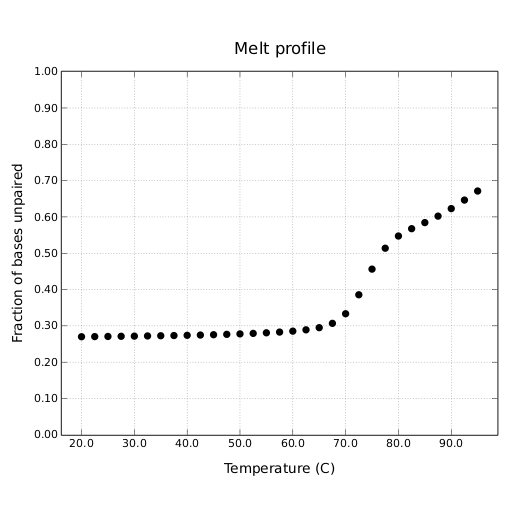

In [50]:
Image(filename='1e_melt.png')

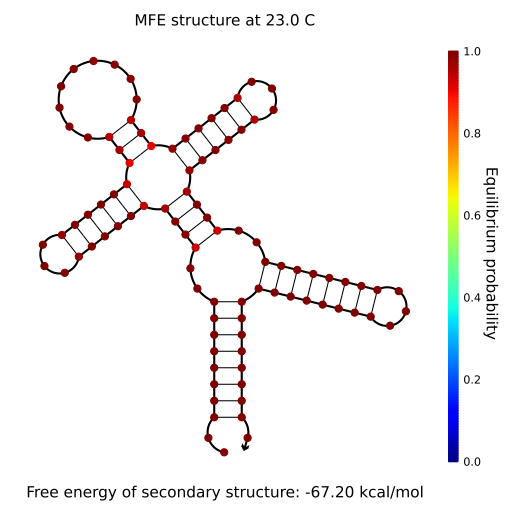

In [54]:
Image(filename='1e_mfe1.png')

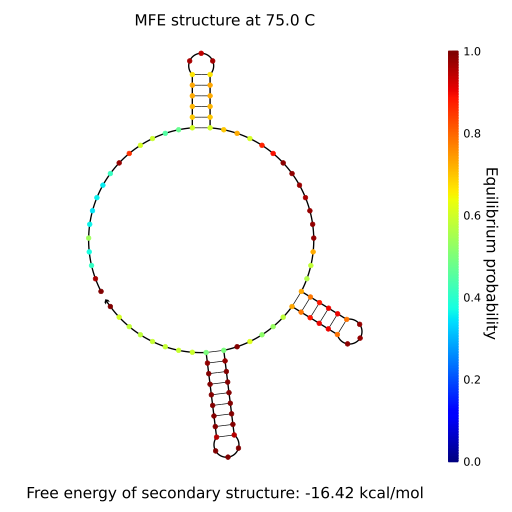

In [52]:
Image(filename='1e_mfe2.png')

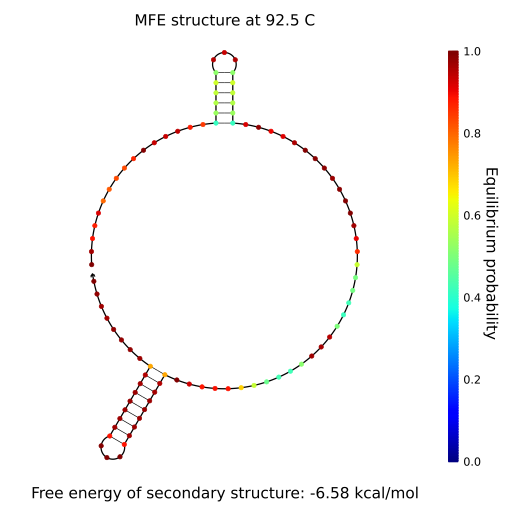

In [53]:
Image(filename='1e_mfe3.png')

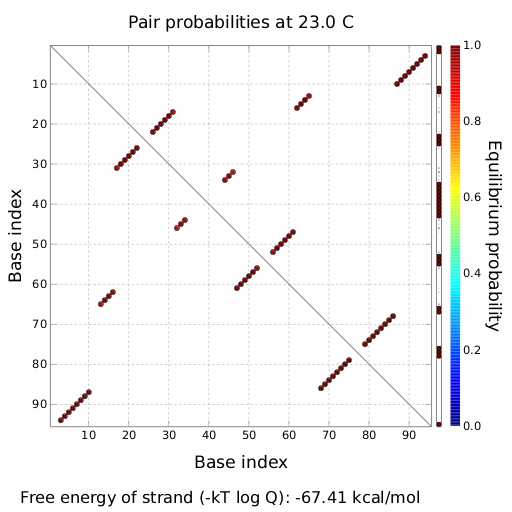

In [55]:
Image(filename='1e_probs.png')

Additionally, we can examine the stability of the structure by looking at the MFE and the pair probabilities matrix at 23 degrees. From the MFE at 23 degrees we can see that the stickman structure should have a pretty high probability because most of the pairs have high probabilities of bonding if they are in the stickman conformation. Additionally from the pair probabilities matrix we see these high probabilities and don't see pairs that we don't want to bind at all which is good. So this structure should be pretty stable at 23 degrees.

f. In order to enforce a 50/50 probability at equilibrium, at first I tried a weighted ensemble defect optimization, but since there are a few more bonds in one of the structures, I couldn't get the probabilities of the two to be equal. Instead, I just tried to optimize the probabilities of the two structures (rather than stabilities) using the built-in NUPACK prob function. This method maximizes the objective function: prob(structA)*prob(structB) which is at a maximum when prob(structA) = prob(structB). The downside of this method though is that it doesn't consider the stabilities of the structures and is purely negative design.

In [21]:
seq = list(randseq('((((((((((..........))))))))))..........'))
struct1 = '((((((((((..........))))))))))..........'
struct2 = '......(((((((((((((........)))))))))))))'
full_pairs = pairs(struct1) + pairs(struct2)
bases = ['A','C','G','U']
for i in range(len(seq)):
    for j in range(len(seq)):
        if full_pairs[i,j] != 0:
            
            # Enforce bonding from struct2 in struct1 sequence
            seq[j] = bases[3-bases.index(seq[i])]
seq = "".join(seq)

def mutatenew(sequence, full_pairs):
    """
    New mutation function to handle base pairing between struct1 and struct2
    """
    N = len(sequence)
    sequence = list(sequence)
    bases = ['A','C','G','U']
    mutation = np.random.randint(N)
    
    # Choose different base to mutate to
    bases.remove(sequence[mutation])
    newbase = bases
    bases = ['A','C','G','U']
    change = np.random.choice(newbase)[0]
    matched_pairs = [mutation]
    
    for i in range(N):
        if full_pairs[mutation,i] != 0:
            matched_pairs += [i]
    sequence[matched_pairs[0]] = change
    
    for i in range (1,len(matched_pairs)):
        
        # Match all base pairs that should be complementary
        sequence[matched_pairs[i]] = bases[3-bases.index(change)]
    sequence = "".join(sequence)
    return sequence

def probopt(seq, struct1, struct2):
    """
    Optimize with respect to probability of formation
    """
    defect1 = 0
    i = 0
    
    # Desired probabilities of structures at equilibrium
    stop = 0.5 * 0.5
    
    # Stop condition
    while i < 1000 and defect1 < stop:
        probs = npk.pairs(seq, T=23)
        test_seq = mutatenew(seq,full_pairs)
        defect0 = npk.prob(seq,struct1,T=23)*npk.prob(seq,struct2,T=23)
        defect1 = npk.prob(test_seq,struct1,T=23)*npk.prob(test_seq,struct2,T=23)
        
        if defect1 > defect0
            i = 0
            seq = test_seq
        else:
            i += 1
    return seq

seq = probopt(seq,struct1,struct2)
print(seq)

GACCUGACGUGAAAAAGACAACGUCAGGUCUUUUUCGCGU


In [26]:
print(npk.prob(seq,struct1,T=23),npk.prob(seq,struct2,T=23))

0.4676 0.4354


Using the above code, we obtain one possible sequence: 'GACCUGACGUGAAAAAGACAACGUCAGGUCUUUUUCGCGU'. The probability that the sequence is found in either of the forms is 47% for s1 and 44% for s2 which is somewhat close to our stop condition of having equal amounts of s1 and s2. However, we can see from the pair probabilities matrix in both the s1 and s2 structures that there is an almost 50% normalized ensemble defect in both structures. This is somewhat to be expected, but it shows that neither of these two structures aren't very stable

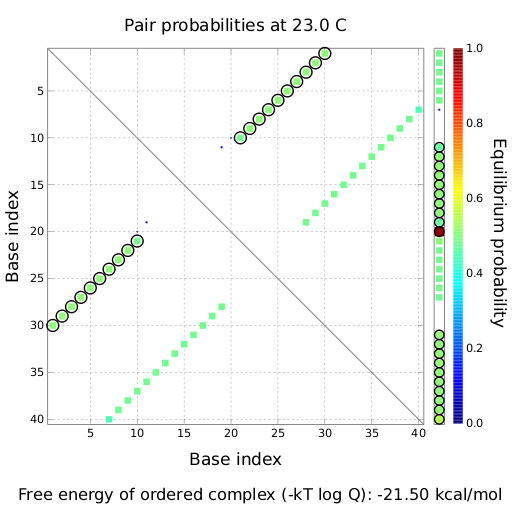

In [27]:
Image(filename='1f_s1.png')

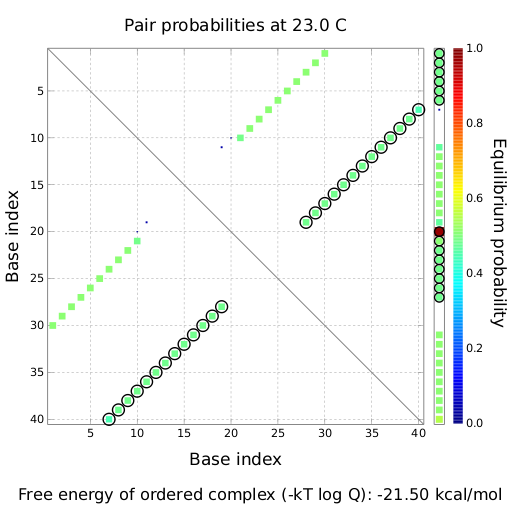

In [28]:
Image(filename='1f_s2.png')

### Problem 2

a. From the starting point of the example AND gate in the paper, we'll try to add an OR gate. However, in our case this is a little tricky since we are constrained with the fact that we're not allowed to use any identical sequences in our initiator strands. If we were allowed to, it's a fairly simple design of adding an extra toe-hold (f) and letting our initiator strands be b*a* (x), ecb (y), cef* (z). However since these have overlapping regions, if we wanted to program the inputs based on mRNA actually present in the genome, it'd be almost impossible to implement this gate in any useful way since it's highly unlikely regions of RNA will have the same sequence. Thus, we need to take advantage of translator strands. In this way, we can define strands x, y, and x to be different, but using translator strands, modify them so that they fit our logic gate. 

b. $\Phi _{fast}$ consists of six different reactions, three for translating each strand (x, y, and z) to their useful form and three for the actual logic. For AND logic, we have a series of 4 reactions involving x and y. First, x is translated by its translator strand. This reaction is thermodynamically favorable because it forms new bonds in the k-sequence. The translated strand is then used to bind to toe-hold region a and reveal toehold b*. After this toehold is revealed, it can be binded by a translated y-sequence. It's important that the translator for y doesn't have a revealed region that can bind to b* so that the reaction only occurs when strand y is present. After y is translated and binds, the output strand (cde) is released as well as the final waste strand that we can use to detect if the reaction has completed via the AND pathway (since it's only a product of the AND reaction).

The OR pathway involves translating the z strand which can then bind to toe-hold f and release the output strand. This also releases a product that can be used to detect and differentiate the OR pathway.

$\Phi _{meta}$ theoretically only consists of the off-target reactions between the translators and our gate since the input strands don't share any sequences (though in reality there'll be inevitable base-pairing between x, y, and z). Thus $\Phi _{meta}$ is a set of three reactions between the gate and the three translators (transx, transy, transz). These reactions are very undesirable because they involve the release of the output and detection strands without the present of any input strands. However, these reactions are also very unfavorable because they don't involve binding between any exposed regions. For example, in the reaction between the gate and transx, only region a is exposed on the gate, while region a is in a duplex in the translator so the reaction between the two should be too slow to matter (especially compared to the reaction when x is added).

$\Psi$ consists of all the relevant reactancts and products, so it includes the 8 boxed structures (output strand and waste products) as well as the three short strands (x, y, and z), translators (transx, transy, transz), and the gate strand (g).

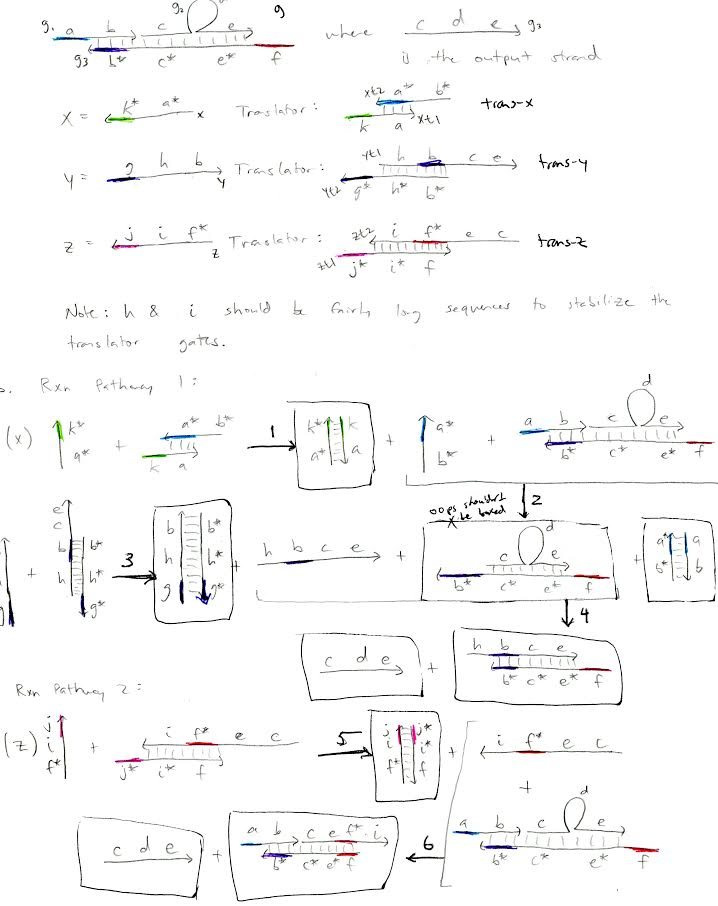

In [3]:
Image(filename='2a.png')

c.

#design material, temperature, and trials
material = dna    
temperature[K] = 298.15    # optional units: C (default) or K
trials = 3    

#target structures
#a = 10, b = 10, c = 10, d = 15, e = 10, f = 10, k = 10, g = 10, h = 20, j = 10, i = 20
structure andGate = U10 D10 (+ D10 (U15 D10 (+ U10)))
structure xS = U20
structure xtrans = U10 D10 (U10 +)
structure yS = U40
structure ytrans = D30 (U20 +) U10
structure zS = U40
structure ztrans = U10 D30 (+ U20)
structure detect1 = U20 D30 (+ U10)
structure detect2 = U10 D10 (+ D30 (U20 +))

#sequence domains
domain a = N10
domain b = N10
domain c = N10
domain d = N15
domain e = N10
domain f = N10
domain g = N10
domain h = N20
domain i = N20
domain j = N10
domain k = N10

#strands (optional, used for threading sequence information 
#and for displaying results)
strand x = a* k*
strand xt1 = k a
strand xt2 = b* a*
strand y = g h b
strand yt1 = h b c e
strand yt2 = b* h* g*
strand z = f* i j
strand zt1 = j* i* f
strand zt2 = c e f* i
strand g1 = a b
strand g2 = c d e
strand g3 = f e* c* b*

#thread strands onto target structures
andGate.seq = g1 g2 g3
xS.seq = x
xtrans.seq = xt1 xt2
yS.seq = y
ytrans.seq = yt1 yt2
zS.seq = z
ztrans.seq = zt1 zt2
detect1.seq = yt1 g3
detect2.seq = g1 zt2 g3

#target test tubes
#(htube should contain only target structures andGate, xtrans, ytrans and 
#ztrans, itube should contain only target structures xS, yS, and zS)
tube htube = andGate xtrans ytrans ztrans
tube itube = xS yS zS

#target concentrations for target structures in test tubes
#default concentration: 1.0e-6 M
htube.andGate.conc[uM] = 2.0  # optional units: M (default), mM, uM, nM, pM 
htube.xtrans.conc[uM] = 1.0
htube.ytrans.conc[uM] = 1.0
htube.ztrans.conc[uM] = 1.0
itube.xS.conc[uM] = 1.0
itube.yS.conc[uM] = 1.0
itube.zS.conc[uM] = 1.0

#design against all off-target ordered complexes of up to this 
#number of strands (design against homodimers and heterodimers)
htube.maxsize = 5
itube.maxsize = 2

#stop conditions for normalized ensemble defect 
#may be specified for a target structure or for a target test tube 
#default: 1.0 percent for each test tube 
#default: 1.0 percent for target structures not assigned 
#to a test tube
#stop conditions for target structures
andGate.stop[%] = 2.0  # optional units: % or frac
xS.stop[%] = 2.0
xtrans.stop[%] = 2.0
yS.stop[%] = 2.0
ytrans.stop[%] = 2.0
xS.stop[%] = 2.0
ztrans.stop[%] = 2.0
detect1.stop[%] = 2.0
detect2.stop[%] = 2.0

#stop conditions for test tubes
htube.stop[%] = 5.0     # optional units: % or frac
itube.stop[%] = 5.0

#prevent sequence patterns
#prevent = AAAA, CCCC, GGGG, UUUU, KKKKKK, MMMMMM, RRRRRR, SSSSSS, WWWWWW, YYYYYY

Using this we got the following sequence:

zt2: TGCTCGGGACGAGCATGAATAACCCCGCCGCCCTTTTGCTTTATATATGA
zt1: GTAGCAAGAGTCATATATAAAGCAAAAGGGCGGCGGGGTT
z: AACCCCGCCGCCCTTTTGCTTTATATATGACTCTTGCTAC
yt2: TAATGTGTGTGGGATCTCGTAACTTGAATGGCTGCTTGGT
yt1: CATTCAAGTTACGAGATCCCACACACATTATGCTCGGGACGAGCATGAAT
y: ACCAAGCAGCCATTCAAGTTACGAGATCCCACACACATTA
xt2: TAATGTGTGTACTTTTCCCG
xt1: TAAAAATAGGCGGGAAAAGT
x: ACTTTTCCCGCCTATTTTTA
g3: CGGCGGGGTTATTCATGCTCGTCCCGAGCATAATGTGTGT
g2: TGCTCGGGACTAATTAAACGATAAGGAGCATGAAT
g1: CGGGAAAAGTACACACATTA

Where the final sequences we want to see in our test tube (for AND and OR logic to work) are the complexes yt1-g3 (AND) and zt2-g3-g1 (OR). Since we started with 2 $\mu$M of the gate strand and 1 $\mu$M of every other strand, we expect that we'll have 2 $\mu$M of our outut strand (g2) and 1 $\mu$M of each of the detect strands. In fact, in our final tube we end up with 2 $\mu$M of the output and 0.96 and 0.95 $\mu$M of the AND and OR output strands respectively. This is looking pretty promising!

Next, let's take a closer look at the ensemble pair fractions. At first glance, the graphic looks pretty good: we see strong binding between toe-hold regions (especially between the x, y, and x sequences and their translators). There is slightly weaker binding between the translated strands and the gate strands (shown by the green lines between zt2/g3, yt1/g3, and xt2/g1). This isn't bad though because the affinity for x, y, and z and the translator strands are so high. Additionally, we see some binding in the hairpin of g2 (output strand) which isn't ideal, but also doesn't really negatively affect our reaction. However, what does affect our reaction is a weak binding interaction between g2 and y1. We can look at this more closely in the pair probabilities of an undesired structure that appears in the tube (yt1/g3/g2)

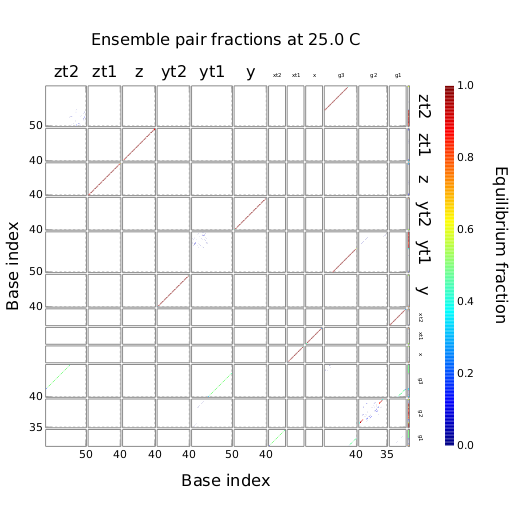

In [56]:
Image(filename='2d_ensemble.png')

This structure is problematic because it's the result of x and y both being translated and translated x and y binding, but the output not releasing. A closer look at the pair probabilities matrix shows that this problem occurs because in our design, there is complementarity between yt1 and g2 (even though none are specified in the original design code). This isn't a terrible problem though since the concentration of this complex is less than 0.05 $\mu$M.

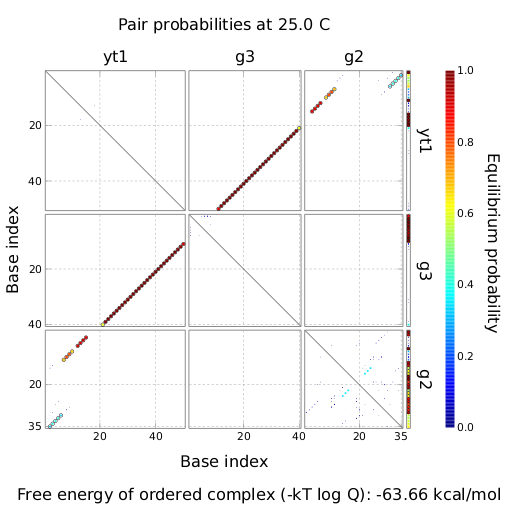

In [57]:
Image(filename='2d_pairs.png')

Finally, we'll take a look at how well our logic works. In the absence of the z-strand (but still with the z-translator), even with an intial 2 $\mu$M concentration of the gate strand, we only get 0.97 $\mu$M of the AND products and 0 $\mu$M of the OR product. Next, we'll see what happens when we have only one of the x or y strands (we'd expect to get no product in this case). This is where we see our first problem. Even in the case where we only have the x-input, (but both x and y translators are present) we still have 0.81 $\mu$M of the output strand (g2) which is very bad because it basically means our AND gate doesn't work very well. The problem in this case is that the entire y-translator forms a complex with the gate strand and releases the output strand. This is due to the meta reaction between the y-translator and gate being too favorable which we could fix if we increased the length of domain h in order to further stabilize the y-translator when the gate has toe-hold b* exposed (due to binding of translated x).

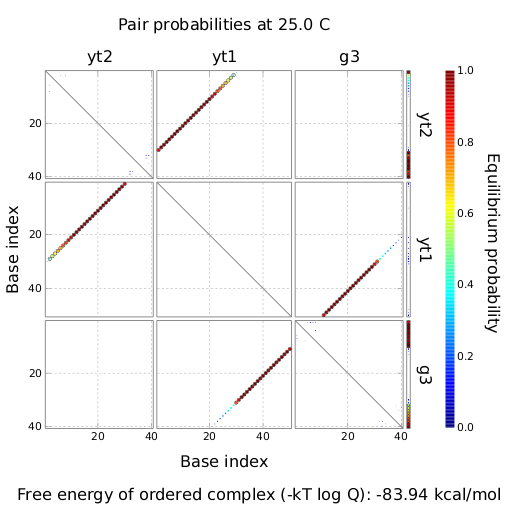

In [58]:
Image(filename='2d_pairs2.png')

We have a similar problem in the absence of input strand x. In this case, xt2 is fully complemntary to g1 so it readily binds even in the absence of strand x. Thinking back on the design, we could have alleviated this problem by adding some complemntarity to domain k in xt2, this way the x-translator would remain in a duplex in the absence of x.

Overall, there are several things we can do to improve the design (add extra complementarity to the translator gates) to implement the AND logic better, however the single design took over 2 days of computation time, so I unfortunately didn't have time to catch the problems in design after analysis.

### Problem 3

In this set of reactions we want to use the three armed junction as a catalyst in a duplex formation reaction. In order to do this, we'll take advantage of the overhang piece coming off each arm of the three-armed junction and use that as the input (toe-hold) for our duplex reaction. This is illustrated in the reaction graphs for formation of the three-armed junction and duplex. However, for our problem although we can have an overhang for all three arms of the junction, we don't want all of them to catalyze the formation of a duplex because this may result in the formation of a duplex before the three armed junction is fully formed. Instead, if we only allow the output gate on the last arm to form to catalyze a duplex reaction we'll only get duplex formation after the three-armed junction is fully formed. Another problem we can forsee is illustrated in the sequential diagram. We can see that the last step is the blue strand replacing the black initiator strand. It is conceivable that at this step the blue strand could catalyze the duplex reaction, however the reaction to complete the three-armed junction is an intramolecular reaction that is much more likel to happen kinetically so it's unlikely that the catalysis of duplex formation happens before releasing the inititator strand.

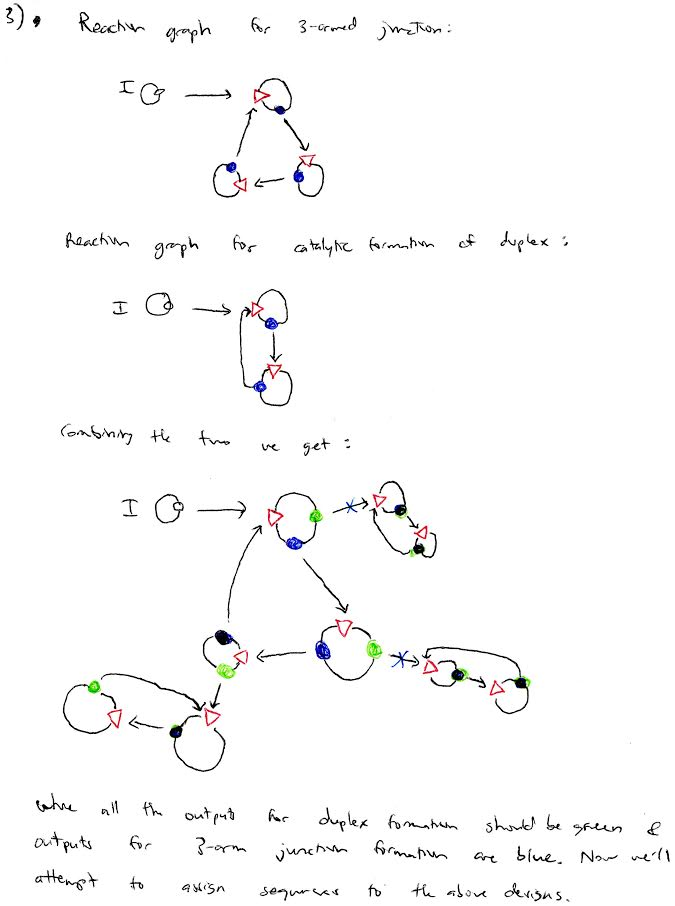

In [4]:
Image(filename='3_1.png')

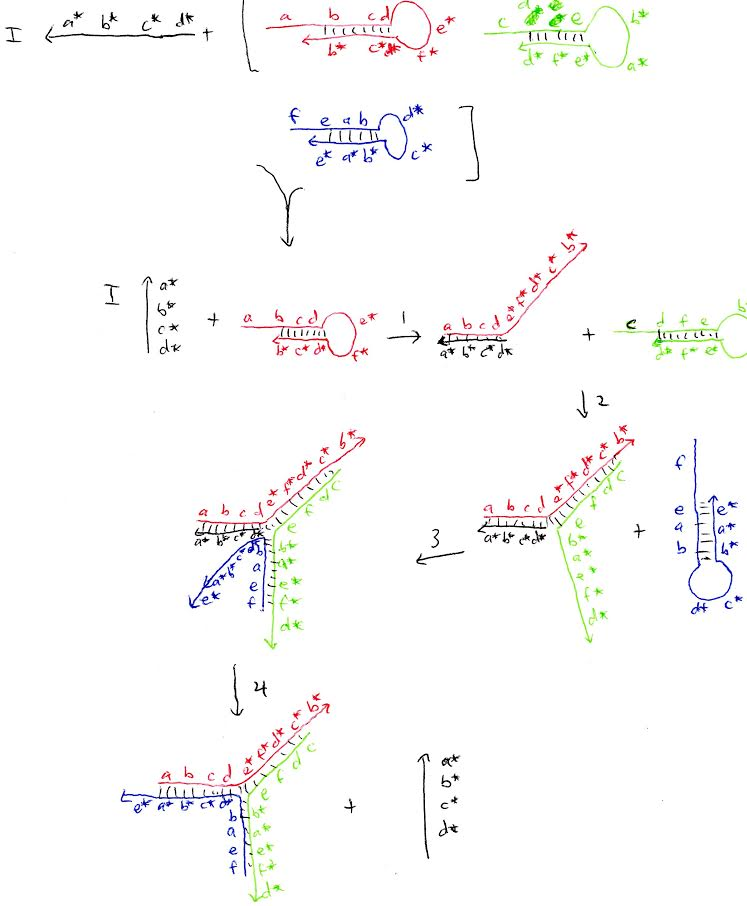

In [5]:
Image(filename='3_2.png')

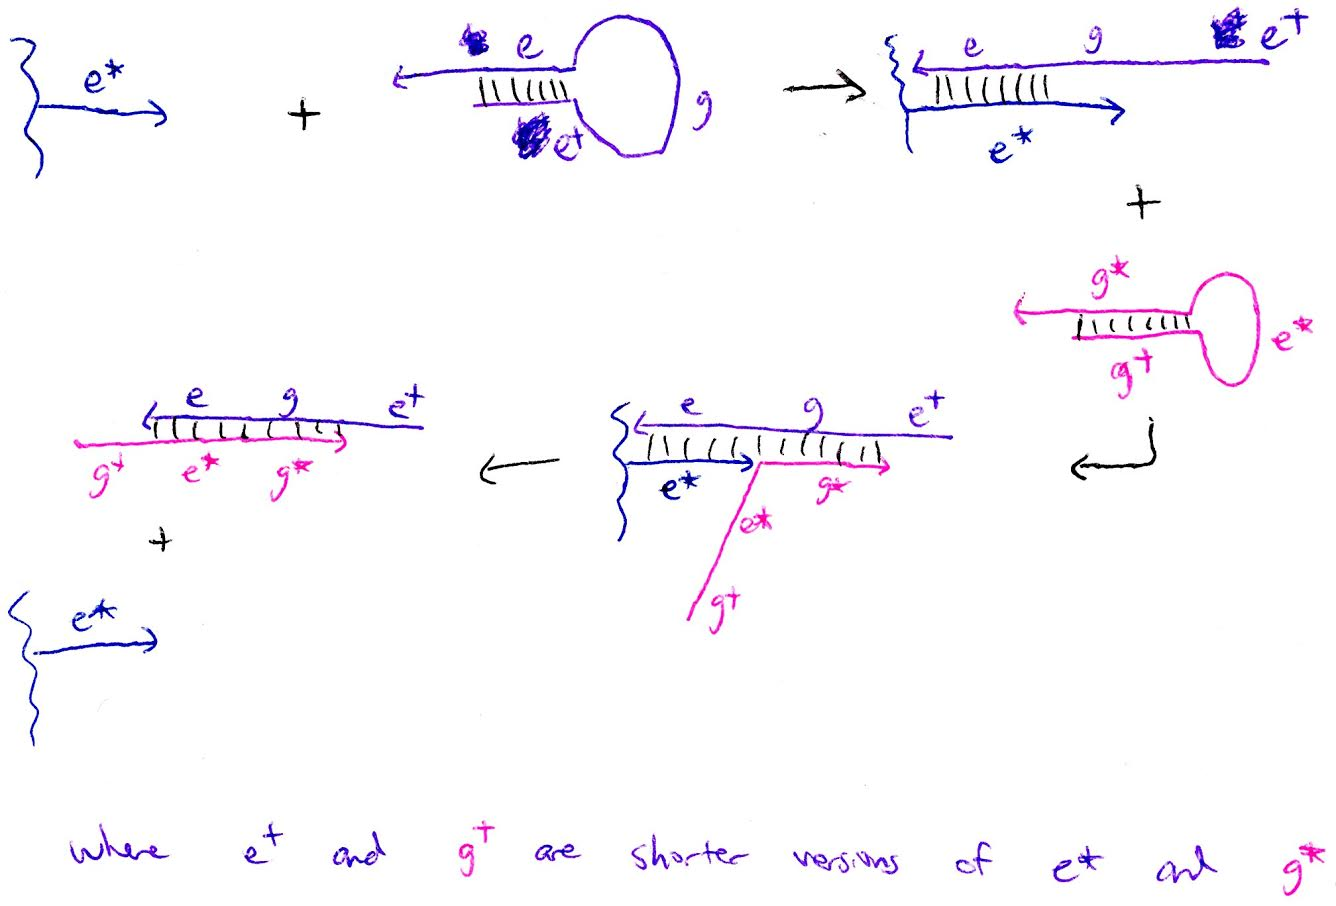

In [6]:
Image(filename='3_3.png')

### Problem 4

a. Since we're given the sequences for I1, H1, and H2, to find how well each design works, we need to evaluate how well I1 binds to H1 in each design. Additionally, we need to make sure that I1 doesn't initiate HCR with H2. The first thing we can look at are the equilibrium concentrations. For both designs, in a test tube with all three sequences (I1, H1, and H2), we don't get any binding of I1 and H2 (concentrations of I1-H2 are 0). We also get slightly better binding between I1 and H1 for Design 2 (concentration of I1-H1 complex is 1 $\mu$M vs 0.99 $\mu$M).

Now, we can consider the MFE structures and pair probability matrices for the I1-H1 complexes in Designs 1 and 2 to determine the viability of each. The following are the MFE structures for the two designs:

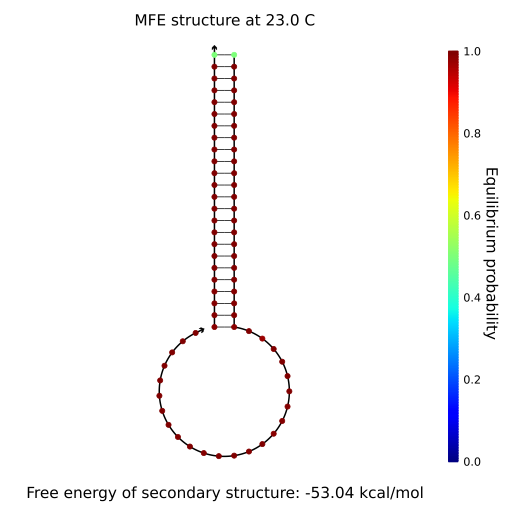

In [166]:
Image(filename='4a_mfe1.png')

For the first design, the MFE looks like the desired structure for initiating HCR for H1. Other than the top two base pairs, all the other base pairs have a high probability for forming this structure. Now we can take a closer look by studying the pair probability matrix:

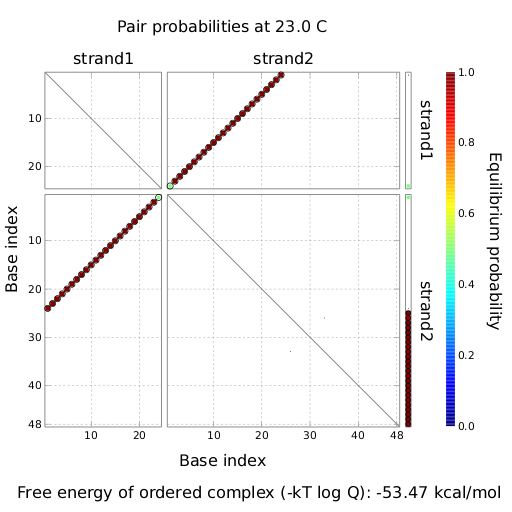

In [168]:
Image(filename='4a_probs1.png')

From the pair-probability matrix we can see that there is a high probability of forming the desired stem and aren't any other likely base pairs which is exactly what we want. Now we'll take a look at the 2nd design.

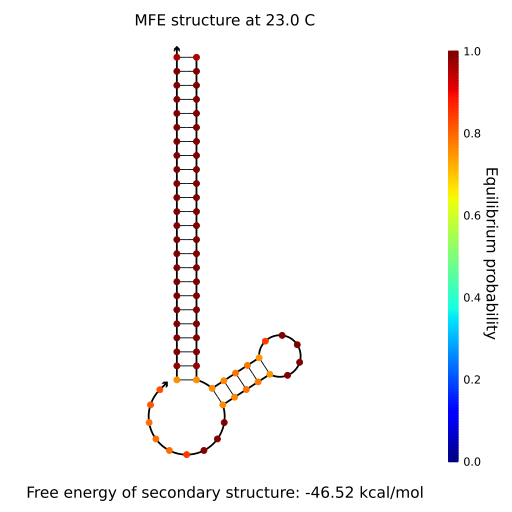

In [10]:
Image(filename='4a_mfe2.png')

From the MFE structure, we can immediately see that there will be a problem with this design. Although like in Design 1, we have good binding on the stem between I1 and H1, the unbound portion of H1 loops back onto itself and forms a hairpin structure which is very bad for the rest of the HCR experiment since the portion in the hairpin loop can't initiate the next reaction with the strand of H2. Taking a look at the pair probabilities matrix confirms this problem:

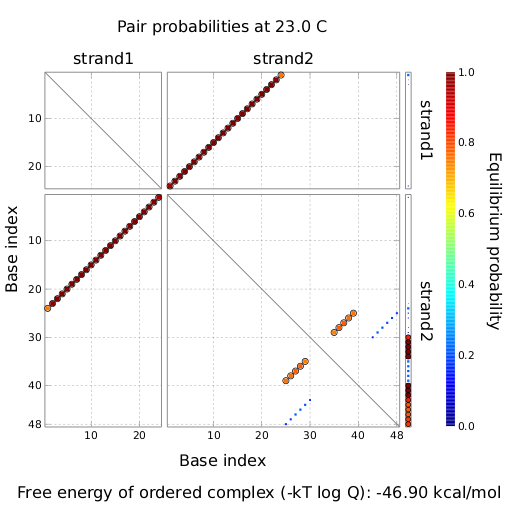

In [11]:
Image(filename='4a_probs2.png')

In the lower right hand corner of the pair probabilities matrix we can see the problematic hairpin forming of the sequence as well as an additional binding sequence (small blue dots) that is not present in the MFE, but is also not desired.

We can see that although the concentration of the I1-H1 complex in Design 2 is higher, the actual structures of the complex are a lot more desirable in Design 1 which makes it preferable to Design 2. Additionally, once we consider binding of H2 to the I1-H1 complex, we see that (according to the ensemble pair fractions) in Design 2, there is essentially no binding of H2 which is very bad. In Design 1 there is some pairing, but the MFE structure and ensemble pair fractions show additional undesired binding which lowers the concentration of the I1-H1-H2 structure to about 0.76 $\mu$M in Design 1.

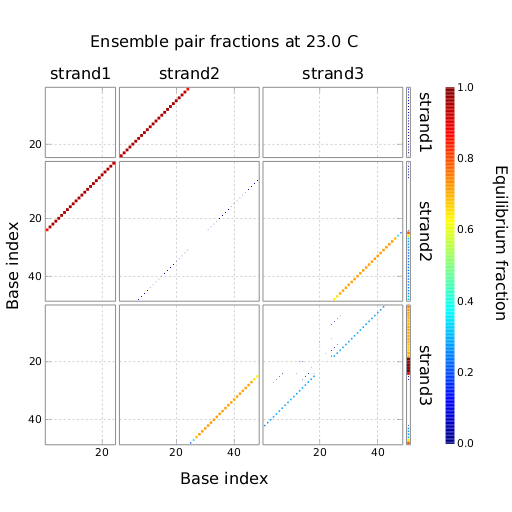

In [8]:
Image(filename='4a_ensemble1.png')

The pair probabilities plot for Design 1 including the H2 strand. We can see that H1 and H2 do bind, however H2 has several undesired binding areas (in the lower right corner) that lead to the MFE structure shown later. Additionally, this graphic explains why our I1-H1-H2 complex is so low in concentration. Both H1 and H2 show significant affinity for themselves which prevents formation of the complex.

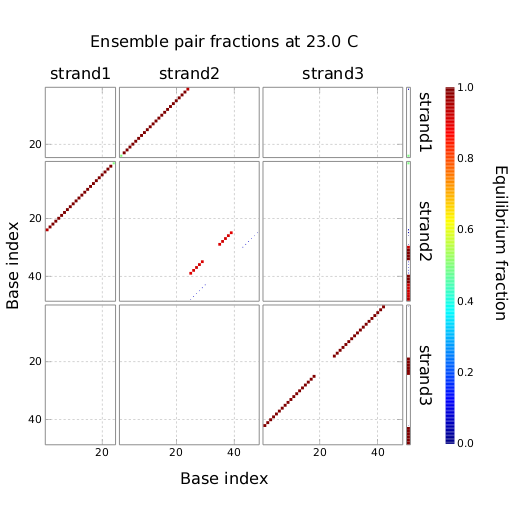

In [175]:
Image(filename='4a_ensemble2.png')

Ensemble pair fractions plot for Design 2 with structure H2 included. We can see that there is a similar hairpin strucutre that we saw before in the I1-H1 complex. Because of this hairpin, H2 cannot bind and instead forms its own hairpin structure which is highly undesired

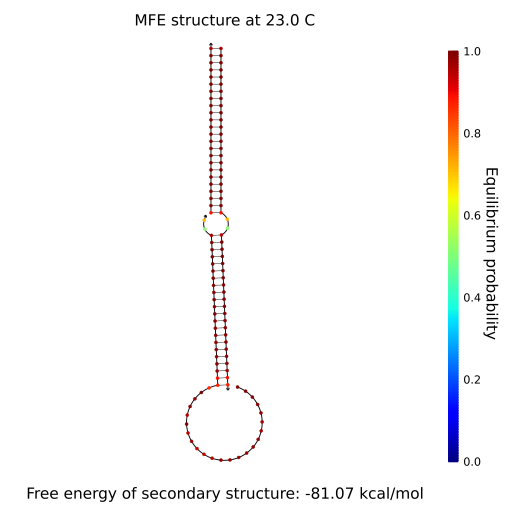

In [9]:
Image(filename='4a_mfe3.png')

Although this structure is connected unlike in Design 2 and looks fairly close to what we want our final product to look like, there's still a bulge in the middle that's undesired and the concentration is too low compared to other species. 

b. From our I1 sequence, we can see that b*a* = CCACACCACAACAACCACATCTCG, so ab = CGAGATGTGGTTGTTGTGGTGTGG. Furthermore, we can see that b* = CCACACCACAACAACCAC, so a* = ATCTCG. So now since we know both a and b, we'll start with using a c length of 6 and design the two hairpins h1 and h2 such that we get the two following structures (from the following script):

#design material, temperature, and trials
material = dna    
temperature[K] = 296.15    # optional units: C (default) or K
trials = 3    

#target structures
structure hairpin1 = U6 D18 U6
structure hairpin2 = D18 U6 U6
structure initiator1 = U24
structure detect1 = D24 + U24

#sequence domains
domain a = CGAGAT
domain b = GTGGTTGTTGTGGTGTGG
domain c = N6

#strands (optional, used for threading sequence information 
#and for displaying results
strand h1 = a b c* b*
strand h2 = b* a* b c
strand i1 = b* a*

#thread strands onto target structures
hairpin1.seq = h1
hairpin2.seq = h2
initiator1.seq = i1
detect1.seq = i1 h1

#target test tubes
#(htube should contain only target structures hairpin1 
#itube should contain only target structure initiator1)
tube htube = hairpin1 hairpin2
tube itube = initiator1

#target concentrations for target structures in test tubes
#default concentration: 1.0e-6 M
htube.hairpin1.conc[uM] = 1.0  # optional units: M (default), mM, uM, nM, pM 
htube.hairpin2.conc[uM] = 1.0
itube.initiator1.conc[uM] = 1.0

#design against all off-target ordered complexes of up to this 
#number of strands (design against homodimers and heterodimers)
htube.maxsize = 2
itube.maxsize = 2

#stop conditions for normalized ensemble defect 
#may be specified for a target structure or for a target test tube 
#default: 1.0 percent for each test tube 
#default: 1.0 percent for target structures not assigned 
#to a test tube
#stop conditions for target structures
hairpin1.stop[%] = 2.0  # optional units: % or frac
hairpin2.stop[%] = 2.0
detect1.stop[%] = 2.0

#stop conditions for test tubes
htube.stop[%] = 5.0     # optional units: % or frac
itube.stop[%] = 5.0

#prevent sequence patterns
prevent = AAAA, CCCC, GGGG, UUUU, KKKKKK, MMMMMM, RRRRRR, SSSSSS, WWWWWW, YYYYYY  

Resulting in the following strands:

h1 = CGAGATGTGGTTGTTGTGGTGTGGAACTCGCCACACCACAACAACCAC

h2 = CCACACCACAACAACCACATCTCGGTGGTTGTTGTGGTGTGGCGAGTT

These two hairpins result in the following MFE and pair probabilities matrix when analyzed (where the I1-H1-H2 complex is at a 0.96 $\mu$M):

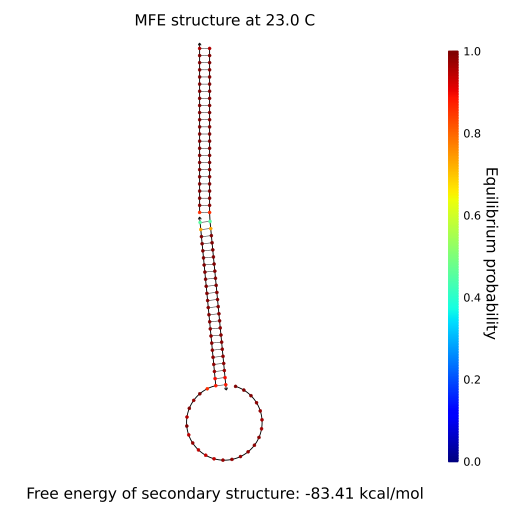

In [5]:
Image(filename='4b_mfe.png')

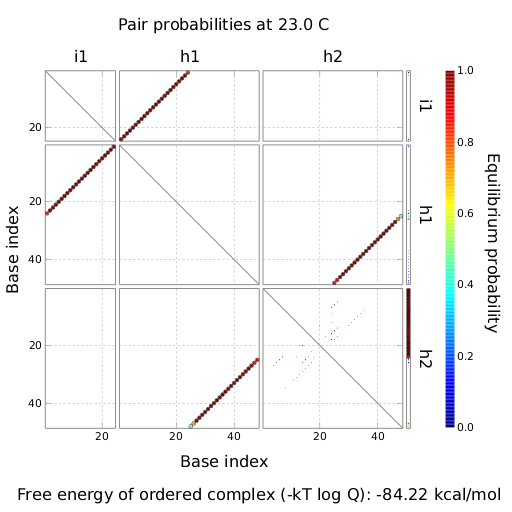

In [6]:
Image(filename='4b_probs.png')

We can see from both these plots that there is a much more desirable I1-H1-H2 structure than when using Design 1 or 2. For example, the MFE doesn't exhibit any undesired hairpin structures or extra bulge loops and incorporates all 3 units nicely while the pair probability matrix shows minimal cross-interactions.

c. $\Phi _{fast}$ includes all the reactions resulting from adding the initiator strand and ending with product. The first reaction (1) involves the addition of the initiator strand to hairpin A. This reaction occurs because the structure makes up for an entropic loss in energy with an extra base pairing sequence (a* from the intiator to a from hairpin A). The resulting product can now initiate a reaction with hairpin B in the same way (reaction 2). This reaction happens one more time, incorporating hairpin C into the complex (reaction 3). Reaction 4 simply replaces the a*/b* sequences from the initiator with the same sequences on hairpin C, thus freeing the initiator to catalyze another reaction. This reaction is favorable because it is neutral in enthalpy, but is entropically favorable because it releases a free strand. This gives us our final product.

The $\Phi _{meta}$ set of reactions include reactions involving only the metastable hairpin structures. These reactions follow a similar mechanism as the reactions in $\Phi _{fast}$, however are much less likely to occur because we are breaking 2 sets of bonds (for example in reaction 1 we break both a b-b* in hairpin A and a c-c* in hairpin B) and only form the same 2 sets of bonds. For this reason, these reactions typically don't happen which is good since we don't want formation of the three-arm junction without addition of the initiator sequence. Additionally, the $\Phi _{meta}$ reactions don't negatively affect the $\Phi _{fast}$ pathway because once any of the $\Phi _{meta}$ reactions occur, the complex can go through the corresponding $\Phi _{fast}$ reactions to form the three-arm junction. An additional reaction in the $\Phi_{meta}$ set involves the initiation of another three-arm junction formation by the last arm of the previous three-arm junction. This happens when the intramolecular reaction that involves kicking off the initiator strand doesn't happen and instead the arm catalyzes another reaction. However since this reaction is intermolecular, it is much slower than the the intramolecular one kicking off the initiator strand.

$\Psi$ simply includes all the intermediates in the $\Phi _{fast}$ pathway as well as the reactants (initiator and hairpins A, B, and C). These structures are boxed in blue and labelled 1-4.

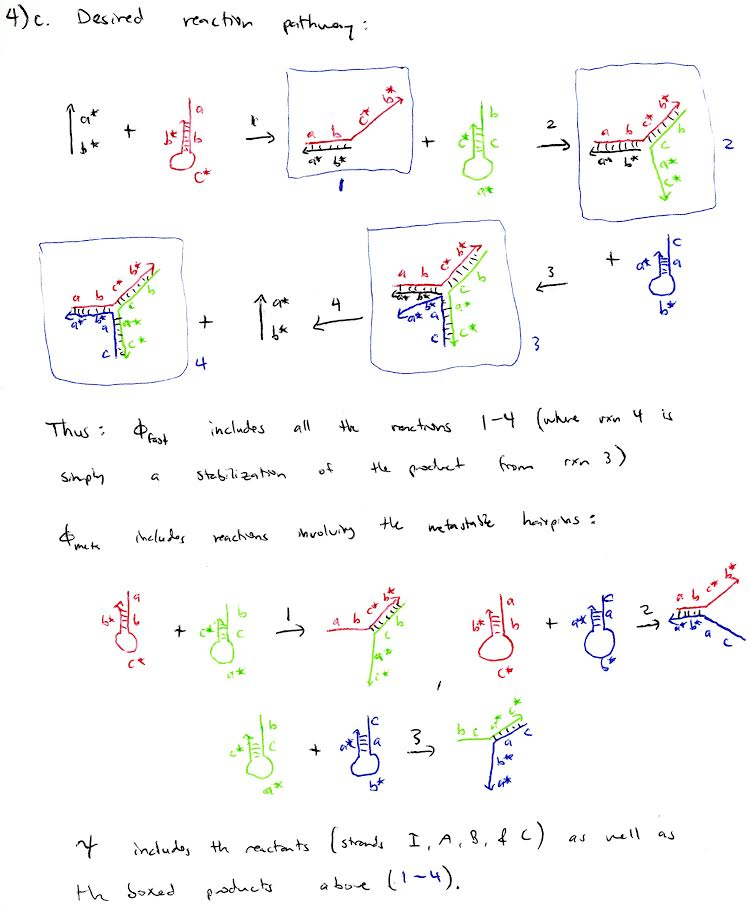

In [7]:
Image(filename='4c.png')

d. 

#design material, temperature, and trials
material = dna    
temperature[K] = 296.15    # optional units: C (default) or K
trials = 3    

#target structures
structure hairpinA = U10 D10 U10
structure hairpinB = U10 D10 U10
structure hairpinC = U10 D10 U10
structure initiator1 = U20
structure detect1 = D20 (D20 (+) D20 (+))

#sequence domains
domain a = N10
domain b = N10
domain c = N10

#strands (optional, used for threading sequence information 
#and for displaying results)
strand hA = a b c* b*
strand hB = b c a* c*
strand hC = c a b* a*
strand i1 = b* a*

#thread strands onto target structures
hairpinA.seq = hA
hairpinB.seq = hB
hairpinC.seq = hC
initiator1.seq = i1
detect1.seq = hA hB hC

#target test tubes
#(htube should contain only target structures hairpinA, hairpinB and 
#hairpinC, itube should contain only target structures and initiator1)
tube htube = hairpinA hairpinB hairpinC
tube itube = initiator1

#target concentrations for target structures in test tubes
#default concentration: 1.0e-6 M
htube.hairpinA.conc[uM] = 1.0  # optional units: M (default), mM, uM, nM, pM 
htube.hairpinB.conc[uM] = 1.0
htube.hairpinC.conc[uM] = 1.0
itube.initiator1.conc[uM] = 1.0

#design against all off-target ordered complexes of up to this 
#number of strands (design against homodimers and heterodimers)
htube.maxsize = 3
itube.maxsize = 2

#stop conditions for normalized ensemble defect 
#may be specified for a target structure or for a target test tube 
#default: 1.0 percent for each test tube 
#default: 1.0 percent for target structures not assigned 
#to a test tube
#stop conditions for target structures
hairpinA.stop[%] = 2.0  # optional units: % or frac
hairpinB.stop[%] = 2.0
hairpinC.stop[%] = 2.0
detect1.stop[%] = 2.0

#stop conditions for test tubes
htube.stop[%] = 5.0     # optional units: % or frac
itube.stop[%] = 5.0

#prevent sequence patterns
prevent = AAAA, CCCC, GGGG, UUUU, KKKKKK, MMMMMM, RRRRRR, SSSSSS, WWWWWW, YYYYYY    


Using this we get the following sequences: 

initiator: CGCATTTGCGAAATCTATTT
hairpin A: AAATAGATTTCGCAAATGCGCTATCTATAGCGCATTTGCG
hairpin B: CGCAAATGCGCTATAGATAGAAATCTATTTCTATCTATAG
hairpin C: CTATAGATAGAAATAGATTTCGCATTTGCGAAATCTATTT

Which form the three-armed junction at a 0.93 concentration in solution. This value is not the best, but it should be okay. We can see that the biggest problem is that the initiator strand has a strong affinity for hairpin A as desired, but also has significant affinity for hairpin B which is bad. Also, hairpins B and C have pretty significant affinties of remaining in their hairpin structures which is also not ideal for forming the three-armed junction. We can see both of these features from the ensemble pair fractions from the blue lines between i1 and hB/hA as well as the blue lines between hC/hC and hB/hB. We can also see from the MFE that there is weak bonding in one of the arms (between hB and hC)

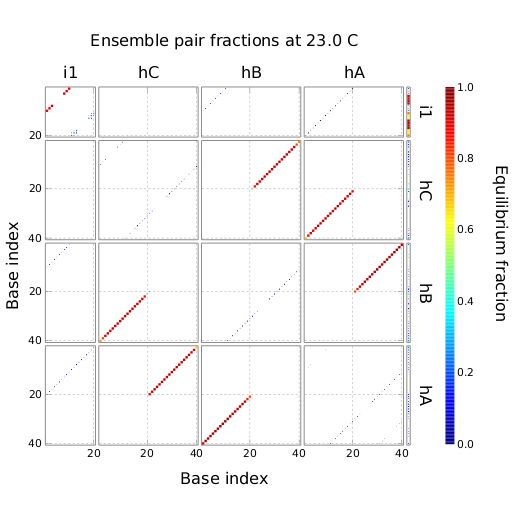

In [42]:
Image(filename='4d_ensemble.png')

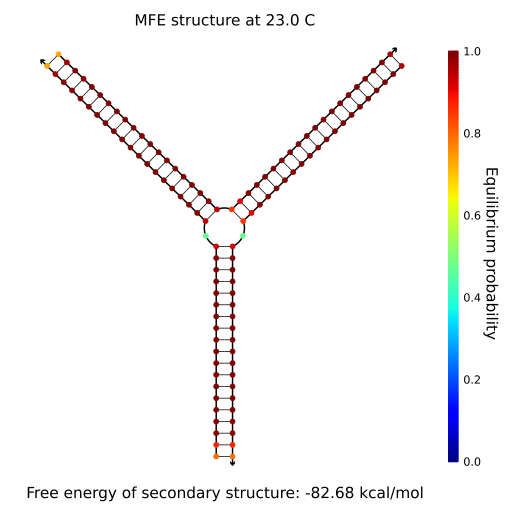

In [43]:
Image(filename='4d_mfe.png')